# 3장 이미지 지역망 : ndimage

In [1]:
import networkx as nx
import numpy as np

from scipy import ndimage as ndi

def add_edge_filter(values, graph):
    center = values[len(values) // 2]
    for neighbor in values:
        if neighbor != center and not graph.has_edge(center, neighbor):
            graph.add_edge(center, neighbor)
    return 0.0


def build_rag(labels, image):
    g = nx.Graph()
    footprint = ndi.generate_binary_structure(labels.ndim, connectivity=1)
    _ = ndi.generic_filter(labels, add_edge_filter, footprint=footprint,
                           mode='nearest', extra_arguments=(g,))
    return g

## 3.1 이미지는 넘파이 배열일 뿐이다

In [2]:
# 그래프를 일렬로 표시하고, 사용자 정의 스타일을 적용한다.
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('style/elegant.mplstyle')

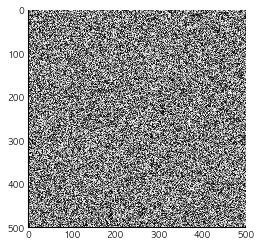

In [4]:
import numpy as np
random_image = np.random.rand(500, 500)
plt.imshow(random_image);

Type: <class 'numpy.ndarray'> Shape: (303, 384) Data type: uint8


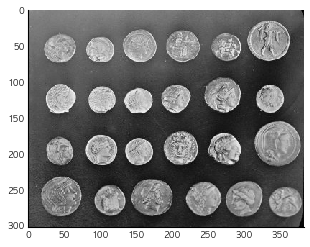

In [5]:
from skimage import io

url_coins = ('https://raw.githubusercontent.com/scikit-image/scikit-image/'
                   'v0.10.1/skimage/data/coins.png')
coins = io.imread(url_coins)
print("Type:", type(coins), "Shape:", coins.shape, "Data type:", coins.dtype)
plt.imshow(coins);

Type: <class 'numpy.ndarray'> Shape: (512, 512, 3) Data type: uint8


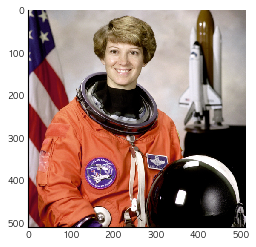

In [6]:
url_astronaut = ('https://raw.githubusercontent.com/scikit-image/scikit-image/'
                          'master/skimage/data/astronaut.png')
astro = io.imread(url_astronaut)
print("Type:", type(astro), "Shape:", astro.shape, "Data type:", astro.dtype)
plt.imshow(astro);

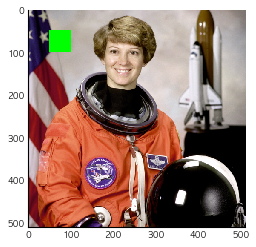

In [7]:
astro_sq = np.copy(astro)
astro_sq[50:100, 50:100] = [0, 255, 0]  # 빨강, 초록, 파랑
plt.imshow(astro_sq);

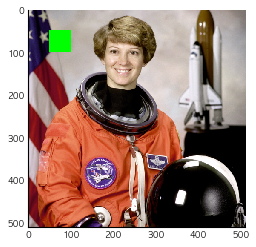

In [8]:
astro_sq = np.copy(astro)
sq_mask = np.zeros(astro.shape[:2], bool)
sq_mask[50:100, 50:100] = True
astro_sq[sq_mask] = [0, 255, 0]
plt.imshow(astro_sq);

## 3.2 신호 처리 필터

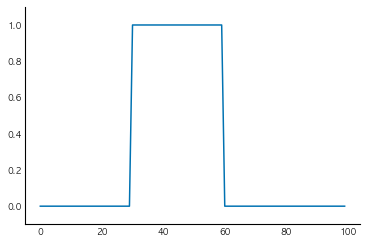

In [18]:
sig = np.zeros(100, np.float) 
sig[30:60] = 1  # signal = 1 # 30-60ms 동안 빛이 측정된다
fig, ax = plt.subplots()
ax.plot(sig);
ax.set_ylim(-0.1, 1.1);

빛 신호가 발생한 시간 : 30 ms


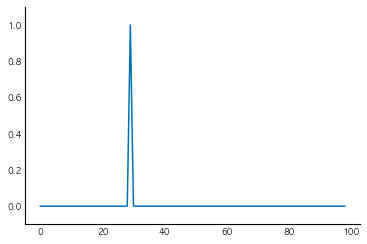

In [19]:
sigdelta = sig[1:]  # sigdelta[0]은 sig[1], sigdelta[1]은 sig[2]... 와 같다.
sigdiff = sigdelta - sig[:-1]
sigon = np.clip(sigdiff, 0, np.inf)
fig, ax = plt.subplots()
ax.plot(sigon)
ax.set_ylim(-0.1, 1.1)
print('빛 신호가 발생한 시간 :', 1 + np.flatnonzero(sigon)[0], 'ms')

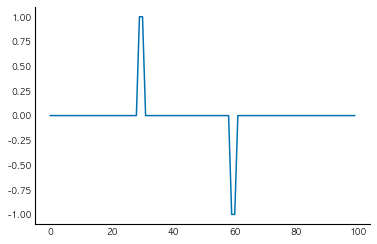

In [20]:
from scipy import ndimage as ndi

diff = np.array([1, 0, -1])
dsig = ndi.convolve(sig, diff)
plt.plot(dsig);

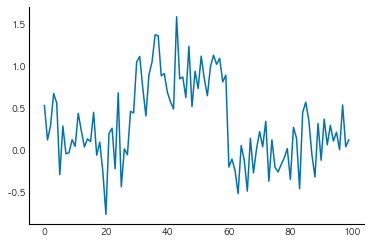

In [21]:
np.random.seed(0)
sig = sig + np.random.normal(0, 0.3, size=sig.shape)
plt.plot(sig);

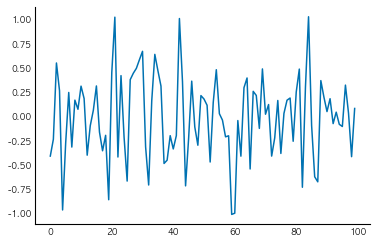

In [22]:
plt.plot(ndi.convolve(sig, diff));

In [23]:
def gaussian_kernel(size, sigma):
    """지정된 크기(size)와 표준 편차의 1차원 가우스 커널을 반환한다.

    충분한 범위를 확보하려면 크기는 홀수여야 하며, 
    시그마(sigma)보다 적어도 6배 이상 커야 한다.
    """
    positions = np.arange(size) - size // 2
    kernel_raw = np.exp(-positions**2 / (2 * sigma**2))
    kernel_normalized = kernel_raw / np.sum(kernel_raw)
    return kernel_normalized

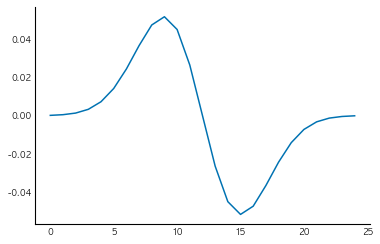

In [24]:
smooth_diff = ndi.convolve(gaussian_kernel(25, 3), diff)
plt.plot(smooth_diff);

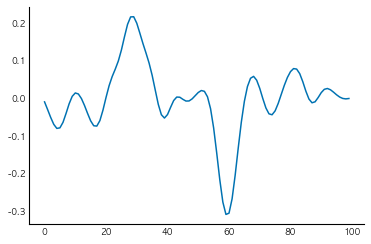

In [25]:
sdsig = ndi.convolve(sig, smooth_diff)
plt.plot(sdsig);

## 3.3 이미지 필터링 (2차원 필터)

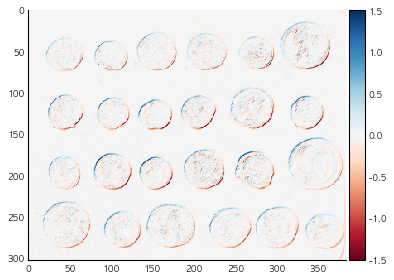

In [26]:
coins = coins.astype(float) / 255  # 오버플로(overflow) 에러 방지
diff2d = np.array([[0, 1, 0], [1, 0, -1], [0, -1, 0]])
coins_edges = ndi.convolve(coins, diff2d)
io.imshow(coins_edges);

In [30]:
# 수평 가장자리를 찾기 위한 열 벡터 (수직)
hdiff = np.array([[1], [0], [-1]])

In [29]:
hsobel = np.array([[ 1,  2,  1],
                  [ 0,  0,  0],
                  [-1, -2, -1]])
vsobel = hsobel.T

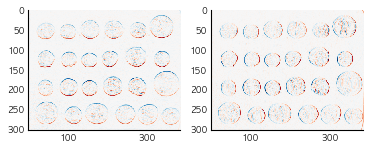

In [33]:
# 그래프를 읽기 쉽게 만드는 사용자 정의 x 축 레이블
def reduce_xaxis_labels(ax, factor):
    """ x 축에 몰리지 않도록, 모든 i 번째 레이블만 보여준다.
        예) factor = 2는 처음부터 매 초마다 x 축 레이블을 그린다.

    매개변수
    ----------
    ax : 맷플롯립 그래프 축
    factor : 정수, x축 레이블 수를 줄이기 위한 요소
    """
    plt.setp(ax.xaxis.get_ticklabels(), visible=False)
    for label in ax.xaxis.get_ticklabels()[::factor]:
        label.set_visible(True)

coins_h = ndi.convolve(coins, hsobel)
coins_v = ndi.convolve(coins, vsobel)

fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(coins_h, cmap=plt.cm.RdBu)
axes[1].imshow(coins_v, cmap=plt.cm.RdBu)
for ax in axes:
    reduce_xaxis_labels(ax, 2)

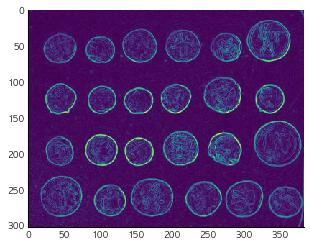

In [34]:
coins_sobel = np.sqrt(coins_h**2 + coins_v**2)
plt.imshow(coins_sobel, cmap='viridis');

## 3.4 제네릭 필터 : 근접값의 임의 함수

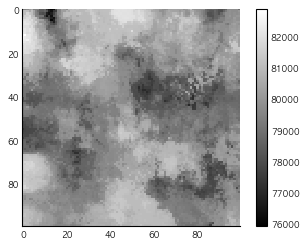

In [35]:
from skimage import morphology

def tax(prices):
    return 10000 + 0.05 * np.percentile(prices, 90)

house_price_map = (0.5 + np.random.rand(100, 100)) * 1e6
footprint = morphology.disk(radius=10)
tax_rate_map = ndi.generic_filter(house_price_map, tax, footprint=footprint)
plt.imshow(tax_rate_map)
plt.colorbar();

## 3.5 그래프와 NetworkX 라이브러리

In [38]:
import pandas as pd

connectome_url = 'http://www.wormatlas.org/images/NeuronConnect.xls'
conn = pd.read_excel(connectome_url)

conn_edges = [(n1, n2, {'weight': s})
              for n1, n2, t, s in conn.itertuples(index=False, name=None)
              if t.startswith('S')]


In [40]:
import networkx as nx

wormbrain = nx.DiGraph()
wormbrain.add_edges_from(conn_edges)

centrality = nx.betweenness_centrality(wormbrain)

central = sorted(centrality, key=centrality.get, reverse=True)
print(central[:5])

['AVAR', 'AVAL', 'PVCR', 'PVT', 'PVCL']


In [42]:
sccs = nx.strongly_connected_component_subgraphs(wormbrain)
giantscc = max(sccs, key=len)
print(f'가장 강력하게 연결된 구성요소는 '
  f'{wormbrain.number_of_nodes()}개 노드 중 '
  f'{giantscc.number_of_nodes()}개 노드다.')

가장 강력하게 연결된 구성요소는 279개 노드 중 237개 노드다.


/Users/achoi/miniconda3/envs/elegant-scipy/lib/python3.6/site-packages/matplotlib/mathtext.py:866: MathTextWarning: Font 'default' does not have a glyph for '-' [U+2212]
  MathTextWarning)
/Users/achoi/miniconda3/envs/elegant-scipy/lib/python3.6/site-packages/matplotlib/mathtext.py:867: MathTextWarning: Substituting with a dummy symbol.
  warn("Substituting with a dummy symbol.", MathTextWarning)


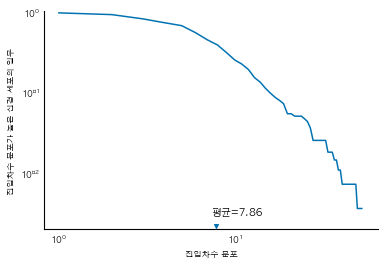

In [45]:
in_degrees = list(dict(wormbrain.in_degree()).values())
in_deg_distrib = np.bincount(in_degrees)
avg_in_degree = np.mean(in_degrees)
cumfreq = np.cumsum(in_deg_distrib) / np.sum(in_deg_distrib)
survival = 1 - cumfreq

fig, ax = plt.subplots()
ax.loglog(np.arange(1, len(survival) + 1), survival)
ax.set_xlabel('진입차수 분포')
ax.set_ylabel('진입차수 분포가 높은 신경 세포의 일부')
ax.scatter(avg_in_degree, 0.0022, marker='v')
ax.text(avg_in_degree - 0.5, 0.003, '평균=%.2f' % avg_in_degree)
ax.set_ylim(0.002, 1.0);

## 3.6 지역 근접 그래프

In [47]:
url = ('http://www.eecs.berkeley.edu/Research/Projects/CS/vision/'
       'bsds/BSDS300/html/images/plain/normal/color/108073.jpg')
tiger = io.imread(url)

from skimage import segmentation

seg = segmentation.slic(tiger, n_segments=30, compactness=40.0,
                                       enforce_connectivity=True, sigma=3)

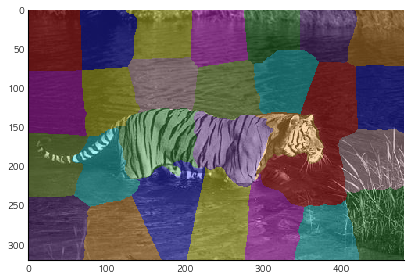

In [48]:
from skimage import color

io.imshow(color.label2rgb(seg, tiger));

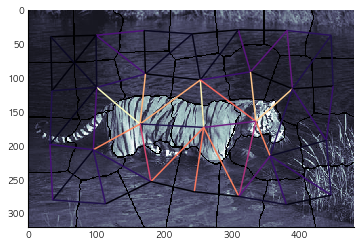

In [49]:
from skimage.future import graph

g = graph.rag_mean_color(tiger, seg)
graph.show_rag(seg, g, tiger);

## 3.7 우아한 ndimage : 이미지 지역에서 그래프 작성하기

In [50]:
import networkx as nx

def build_rag(labels, image):
    g = nx.Graph()
    nrows, ncols = labels.shape
    for row in range(nrows):
        for col in range(ncols):
            current_label = labels[row, col]
            if not current_label in g:
                g.add_node(current_label)
                g.node[current_label]['total color'] = np.zeros(3, dtype=np.float)
                g.node[current_label]['pixel count'] = 0
            if row < nrows - 1 and labels[row + 1, col] != current_label:
                g.add_edge(current_label, labels[row + 1, col])
            if col < ncols - 1 and labels[row, col + 1] != current_label:
                g.add_edge(current_label, labels[row, col + 1])
            g.node[current_label]['total color'] += image[row, col]
            g.node[current_label]['pixel count'] += 1
    return g

In [51]:
import networkx as nx

def build_rag_3d(labels, image):
    g = nx.Graph()
    nplns, nrows, ncols = labels.shape
    for pln in range(nplns):
        for row in range(nrows):
            for col in range(ncols):
                current_label = labels[pln, row, col]
                if not current_label in g:
                    g.add_node(current_label)
                    g.node[current_label]['total color'] = np.zeros(3, dtype=np.float)
                    g.node[current_label]['pixel count'] = 0
                if pln < nplns - 1 and labels[pln + 1, row, col] != current_label:
                    g.add_edge(current_label, labels[pln + 1, row, col])
                if row < nrows - 1 and labels[pln, row + 1, col] != current_label:
                    g.add_edge(current_label, labels[pln, row + 1, col])
                if col < ncols - 1 and labels[pln, row, col + 1] != current_label:
                    g.add_edge(current_label, labels[pln, row, col + 1])
                g.node[current_label]['total color'] += image[pln, row, col]
                g.node[current_label]['pixel count'] += 1
    return g

In [53]:
import networkx as nx
import numpy as np
from scipy import ndimage as nd

def add_edge_filter(values, graph):
    center = values[len(values) // 2]
    for neighbor in values:
        if neighbor != center and not graph.has_edge(center, neighbor):
            graph.add_edge(center, neighbor)
    # 반환값은 사용되지 않지만, generic_filter() 함수에서 필요하다.
    return 0.0

def build_rag(labels, image):
    g = nx.Graph()
    footprint = ndi.generate_binary_structure(labels.ndim, connectivity=1)
    _ = ndi.generic_filter(labels, add_edge_filter, footprint=footprint,
                           mode='nearest', extra_arguments=(g,))
    for n in g:
        g.node[n]['total color'] = np.zeros(3, np.double)
        g.node[n]['pixel count'] = 0
    for index in np.ndindex(labels.shape):
        n = labels[index]
        g.node[n]['total color'] += image[index]
        g.node[n]['pixel count'] += 1
    return g

## 3.8 평균 색상 분할

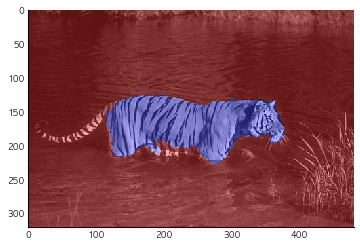

In [56]:
g = build_rag(seg, tiger)
for n in g:
    node = g.node[n]
    node['mean'] = node['total color'] / node['pixel count']
for u, v in g.edges():
    d = g.node[u]['mean'] - g.node[v]['mean']
    g[u][v]['weight'] = np.linalg.norm(d)


def threshold_graph(g, t):
    to_remove = [(u, v) for (u, v, d) in g.edges(data=True)
                 if d['weight'] > t]
    g.remove_edges_from(to_remove)

threshold_graph(g, 80)

map_array = np.zeros(np.max(seg) + 1, int)
for i, segment in enumerate(nx.connected_components(g)):
    for initial in segment:
        map_array[int(initial)] = i
segmented = map_array[seg]
plt.imshow(color.label2rgb(segmented, tiger));